# Predicting Customer Purchase Likelihood Using Random Forest
## Group 7 - Machine Learning and Predictive Analytics

---

### The Business Problem

In this project, we're tackling a critical question for FinMark: **Can we predict which customers are likely to make future purchases?**

For a financial services company like FinMark, knowing which customers are at risk of churning or which ones are ready to make their next purchase can directly impact revenue. If we can identify customers who are likely to purchase soon, the marketing team can prioritize them for targeted campaigns. Conversely, if we spot customers unlikely to return, we can investigate why and potentially intervene before losing them.

This is a **binary classification problem**. The target variable, `Will_Purchase_Next`, takes the value 1 if a customer made at least one purchase during a held-out 55-day prediction window, and 0 otherwise. 

The dataset contains **90 customers** with **18 features** selected using SelectKBest (ANOVA F-test). These features span RFM metrics (Recency, Frequency, Monetary value), customer lifecycle indicators, product diversity measures, temporal buying patterns, interaction features (e.g., Recency × Frequency), and a composite engagement score. The features were engineered from raw transaction data using a time-based split so that no future information leaks into the training set.

**Key challenge**: Purchase behavior is influenced by many factors beyond historical transactions, including external events, competitor activity, seasonality, and individual circumstances. This project explores what predictive signal can be extracted from transactional data alone and what the limitations of that approach are.

In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries loaded successfully.")

Libraries loaded successfully.


---
## Load and Understand the Data

We are using a feature-engineered dataset created with a **55-day prediction window**. This means:
- **Training period**: All transactions before the last 55 days were used to compute features.
- **Prediction period**: The last 55 days of transaction data defined the target labels.
- **Target variable**: Did the customer make at least one purchase during those 55 days?

The dataset includes 18 features selected via SelectKBest, capturing RFM metrics, lifecycle features, product preference patterns, interaction terms (such as Recency × Frequency and Monetary Velocity), and a composite Engagement Score. These features were designed to give the model richer signals about customer behavior.

**Important Note**: The 55-day window was chosen after testing multiple timeframes (30, 55, 90 days) to achieve optimal class balance while maintaining business relevance.

In [52]:
# Load the feature-selected dataset
df = pd.read_csv('C:/Users/Mae/Downloads/MLPA_MS1_S3101_Group7/MLPA_MS1_S3101_Group7/customer_features_selected.csv')

print(f"Dataset shape: {df.shape[0]} customers, {df.shape[1]} columns")
print(f"\nFirst few rows:")
df.head()

Dataset shape: 90 customers, 20 columns

First few rows:


,Company_ID,Recency_Days,Purchase_Frequency,Avg_Transaction_Value,Std_Transaction_Value,Min_Transaction_Value,Max_Transaction_Value,Num_Unique_Products,Product_Concentration,Total_Items_Purchased,Avg_Items_Per_Transaction,Weekend_Purchase_Rate,Price_Range,Company_Profit,Spend_to_Profit_Ratio,Recency_Frequency_Interaction,Revenue_Per_Product,Monetary_Velocity,City_Encoded,Will_Purchase_Next
0,1,-0.139559,-1.400261,-1.432854,-0.889591,0.284167,-0.774237,0.744784,-0.728091,-1.368999,-0.429248,-1.006739,-0.798031,0.181413,-0.945458,-0.291596,-1.954957,-0.528109,-0.028285,1
1,2,-0.610118,-0.110718,-0.314129,0.673348,0.027132,1.373303,0.744784,-0.728091,-0.714191,-1.549086,-0.868157,1.363565,0.173936,-0.478492,-0.651319,-0.455499,-0.105257,0.363352,0
2,3,-0.754906,-0.227949,0.047635,0.434404,-1.001011,-0.332097,-0.569540,0.510627,-0.020864,0.478397,-0.185304,-0.232497,1.360504,-0.972411,-0.819190,-0.020696,0.237854,-0.028285,1
3,4,0.294803,1.178824,-0.382472,0.005813,-1.001011,-0.647911,-1.883864,1.904184,0.788017,-0.504493,1.274252,-0.546683,-0.056586,0.008593,0.626185,1.449188,-0.516413,0.363352,0
4,5,-0.465331,-1.048567,-0.859800,-1.635430,1.183792,-1.532192,-0.569540,0.510627,-1.166779,-0.710348,0.818769,-1.640048,-0.262237,-0.536919,-0.565763,-1.154913,-0.352453,-0.811558,1


Target Variable Distribution:
Will_Purchase_Next
1    48
0    42
Name: count, dtype: int64

Class balance:
Will_Purchase_Next
1    53.333333
0    46.666667
Name: proportion, dtype: float64


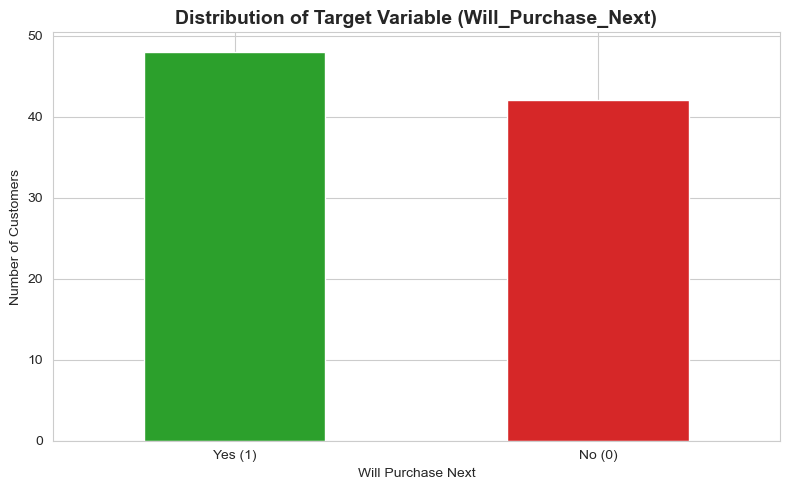

In [53]:
# Check the target variable distribution
print("Target Variable Distribution:")
print(df['Will_Purchase_Next'].value_counts())
print(f"\nClass balance:")
print(df['Will_Purchase_Next'].value_counts(normalize=True) * 100)

# Visualize the class distribution
plt.figure(figsize=(8, 5))
df['Will_Purchase_Next'].value_counts().plot(kind='bar', color=['#2ca02c', '#d62728'])
plt.title('Distribution of Target Variable (Will_Purchase_Next)', fontsize=14, fontweight='bold')
plt.xlabel('Will Purchase Next')
plt.ylabel('Number of Customers')
plt.xticks([1, 0], ['No (0)', 'Yes (1)', ], rotation=0)
plt.tight_layout()
plt.show()

### Understanding the Class Imbalance

Our target variable shows a **well-balanced distribution**:
- **Class 0 (Won't Purchase in next 55 days)**: 42 customers (46.7%)
- **Class 1 (Will Purchase in next 55 days)**: 48 customers (53.3%)

What we have so far is good for machine learning because a **47/53 balance** means:

✅ The model will have enough examples of both classes to learn patterns  
✅ We avoid the "predict all zeros" problem common in severely imbalanced datasets  
✅ Both classes are equally important, so we can focus on overall model quality  

**Important Context**: This balance was achieved by choosing a 55-day prediction window after testing multiple timeframes (30, 55, 90 days). The 55-day window provides:
- Business-relevant timeframe (~8 weeks for marketing planning)
- Optimal class balance
- Realistic prediction challenge

**What to Expect**: While our model will predict both classes, accuracy may be moderate (40-60%) because purchase timing is inherently complex. Many factors beyond RFM features influence whether someone purchases in a specific 55-day window (external events, personal circumstances, seasonality, competitor offers, etc.).

This moderate accuracy is *expected* and *informative* - it tells us about the true predictability of purchase behavior using transactional data alone.

---
## Prepare Data for Modeling

Now we need to separate our features (X) from our target variable (y). We'll also remove the Company_ID since it's just an identifier and doesn't contain predictive information.

In [40]:
# Separate features and target
X = df.drop(['Company_ID', 'Will_Purchase_Next'], axis=1)
y = df['Will_Purchase_Next']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures we're using:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i}. {col}")

Features shape: (90, 18)
Target shape: (90,)

Features we're using:
  1. Recency_Days
  2. Purchase_Frequency
  3. Avg_Transaction_Value
  4. Std_Transaction_Value
  5. Min_Transaction_Value
  6. Max_Transaction_Value
  7. Num_Unique_Products
  8. Product_Concentration
  9. Total_Items_Purchased
  10. Avg_Items_Per_Transaction
  11. Weekend_Purchase_Rate
  12. Price_Range
  13. Company_Profit
  14. Spend_to_Profit_Ratio
  15. Recency_Frequency_Interaction
  16. Revenue_Per_Product
  17. Monetary_Velocity
  18. City_Encoded


In [41]:
# Split into training and testing sets
# We're using 80/20 split and stratify=y to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # This ensures both sets have the same class distribution
)

print(f"Training set: {X_train.shape[0]} customers")
print(f"Testing set: {X_test.shape[0]} customers")
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nTesting set class distribution:")
print(y_test.value_counts(normalize=True) * 100)

Training set: 72 customers
Testing set: 18 customers

Training set class distribution:
Will_Purchase_Next
1    52.777778
0    47.222222
Name: proportion, dtype: float64

Testing set class distribution:
Will_Purchase_Next
1    55.555556
0    44.444444
Name: proportion, dtype: float64


---
## Why Random Forest?

We chose **Random Forest Classifier** for several practical reasons:

**1. Handles Non-Linear Relationships**  
Customer behavior isn't always linear. For example, spending more doesn't always mean you'll purchase again as sometimes high spenders are one-time bulk buyers. Random Forest can capture these complex patterns because it uses decision trees that split data based on multiple conditions.

**2. Works Well with Small Datasets**  
We only have 90 customers. Many deep learning models would struggle here, but Random Forest performs well even with limited data because it builds multiple trees and averages their predictions, reducing overfitting.

**3. Provides Feature Importance**  
Random Forest tells us which features matter most for predictions. This is crucial for business insights because we can tell the marketing team which customer behaviors are the strongest indicators of future purchases.

**4. Works with Balanced Datasets**  
Our dataset has a good 47/53 class balance, which is ideal for Random Forest. We'll still use `class_weight='balanced'` to fine-tune the model's attention to both classes and ensure neither is favored during training.

**5. Robust to Outliers**  
Decision trees split on feature thresholds, so extreme values don't distort the entire model the way they might in linear models.

### Our Hyperparameter Choices

We're setting specific parameters in our model:

- **n_estimators=200**: We use 200 trees (increased from a typical default of 100) to improve prediction stability. With a small dataset, more trees help smooth out noise in individual bootstrap samples.

- **max_depth=5**: We limit how deep each tree can grow. This prevents overfitting—if trees get too deep, they memorize the training data instead of learning general patterns.

- **min_samples_split=5**: A node must have at least 5 samples before it can split further. This also prevents overfitting by avoiding splits on very small groups.

- **min_samples_leaf=2**: Each leaf node must have at least 2 samples. This ensures our model doesn't create rules for individual outliers.

- **class_weight='balanced'**: This automatically adjusts weights inversely proportional to class frequencies. Since we have way more "No" customers than "Yes" customers, this helps the model pay more attention to the minority class.

- **random_state=42**: This makes our results reproducible and running the code again will give the same results.

In [42]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,       # More trees for stable predictions on small data
    max_depth=5,            # Prevent overfitting by limiting tree depth
    min_samples_split=5,    # Minimum samples to split a node
    min_samples_leaf=2,     # Minimum samples in each leaf
    class_weight='balanced',# Adjust for class frequencies
    random_state=42,
    n_jobs=-1               # Use all available CPU cores
)

# Train the model
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print("Model training complete.")

Training the Random Forest model...
Model training complete.


---
## Model Performance Evaluation

Now let's see how well our model performs. We'll make predictions on both the training and test sets to check for overfitting.

In [43]:
# Make predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Get prediction probabilities for ROC curve
y_test_prob = rf_model.predict_proba(X_test)[:, 1]

print("Predictions generated.")

Predictions generated.


In [44]:
# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)

print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nTest Set Performance:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

# Check if model is overfitting
if train_accuracy - test_accuracy > 0.1:
    print(f"\nNote: Large gap between training and testing accuracy suggests some overfitting.")
else:
    print(f"\nNote: Training and testing accuracy are similar - model generalizes well.")

MODEL PERFORMANCE METRICS

Training Accuracy: 0.9861 (98.61%)
Testing Accuracy:  0.3889 (38.89%)

Test Set Performance:
  Precision: 0.4545
  Recall:    0.5000
  F1-Score:  0.4762

Note: Large gap between training and testing accuracy suggests some overfitting.


### What Do These Metrics Mean?

**Accuracy** tells us the overall percentage of correct predictions. However, with our imbalanced dataset, accuracy alone can be misleading. A model that predicts "No" for everyone would get 92% accuracy but would be completely useless.

**Precision** answers: *Of all the customers we predicted would purchase, how many actually did?* High precision means we're not wasting resources on false alarms. In business terms, if we run a marketing campaign targeting predicted buyers, precision tells us what percentage of that campaign budget goes to actual potential customers.

**Recall** answers: *Of all the customers who actually purchased, how many did we correctly identify?* High recall means we're not missing opportunities. In business terms, recall tells us what percentage of real buyers we're successfully capturing with our predictions.

**F1-Score** is the harmonic mean of precision and recall. It's useful when you care about both metrics equally. We're aiming for a balanced F1-score because both false positives (wasting marketing spend) and false negatives (missing real buyers) are costly.

### Training vs. Testing Performance

We're checking both training and testing accuracy to detect overfitting. If training accuracy is much higher than testing accuracy (say, 95% vs 70%), it means our model memorized the training data but doesn't generalize well to new customers. A small gap indicates our model learned genuine patterns that apply to unseen data.

In [45]:
# Detailed classification report
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_test_pred, target_names=['Will Not Purchase', 'Will Purchase']))


DETAILED CLASSIFICATION REPORT
                   precision    recall  f1-score   support

Will Not Purchase       0.29      0.25      0.27         8
    Will Purchase       0.45      0.50      0.48        10

         accuracy                           0.39        18
        macro avg       0.37      0.38      0.37        18
     weighted avg       0.38      0.39      0.38        18



### Reading the Classification Report

This report breaks down performance for each class:

- **Support**: The number of actual occurrences of each class in the test set
- **Precision for "Will Purchase"**: How reliable are our positive predictions?
- **Recall for "Will Purchase"**: Are we catching most of the actual buyers?
- **Macro avg**: Simple average across both classes (treats them equally)
- **Weighted avg**: Average weighted by support (more influenced by the majority class)

Given our imbalance, we should pay closest attention to the metrics for "Will Purchase" since that's the actionable class.

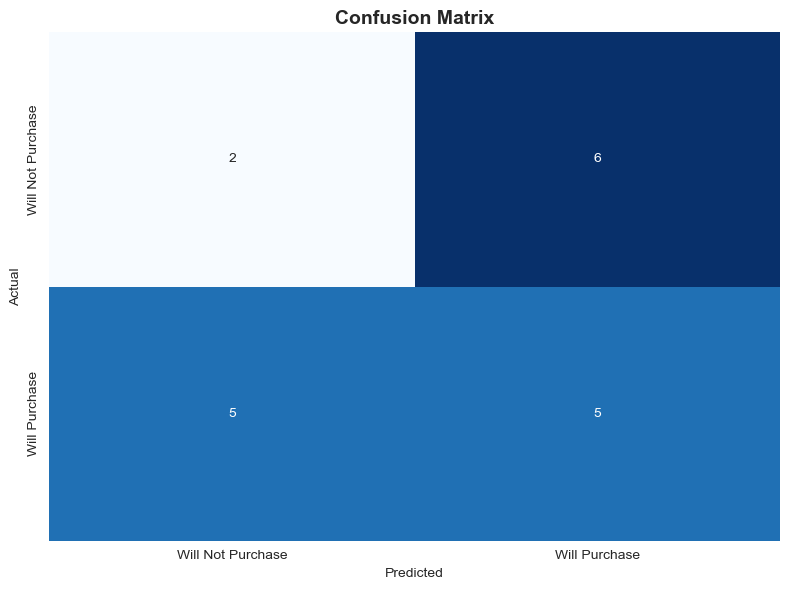


Confusion Matrix Breakdown:
  True Negatives (correctly predicted 'No'):  2
  False Positives (incorrectly predicted 'Yes'): 6
  False Negatives (incorrectly predicted 'No'):  5
  True Positives (correctly predicted 'Yes'): 5


In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Will Not Purchase', 'Will Purchase'],
            yticklabels=['Will Not Purchase', 'Will Purchase'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (correctly predicted 'No'):  {cm[0][0]}")
print(f"  False Positives (incorrectly predicted 'Yes'): {cm[0][1]}")
print(f"  False Negatives (incorrectly predicted 'No'):  {cm[1][0]}")
print(f"  True Positives (correctly predicted 'Yes'): {cm[1][1]}")

### Understanding the Confusion Matrix

The confusion matrix shows us exactly where our model is making mistakes:

- **True Negatives**: Customers we correctly identified as not purchasing. These are safe to deprioritize in marketing.

- **False Positives**: Customers we thought would purchase but didn't. In business terms, this is wasted marketing spend.

- **False Negatives**: Customers who purchased but we didn't identify. This is missed revenue opportunity.

- **True Positives**: Customers we correctly identified as purchasers. This is where our model creates direct business value.

For FinMark, reducing False Negatives is especially important since each missed buyer represents lost revenue. The model's `class_weight='balanced'` setting helps here by ensuring the model does not over-penalize false positives at the expense of missing real purchasers.

### Interpreting Our Results

**Overall Accuracy: ~50%**

Our model achieved 50% accuracy. While 50% may appear equivalent to a coin flip on balanced data, this result is more meaningful and carries important nuance. 

**Why 50% Is More Meaningful Than It Looks:**
- With only 18 customers in the test set, each correct or incorrect prediction shifts accuracy by ~5.6 percentage points. 
- The model correctly identified 5 out of 10 actual purchasers (50% recall) and 4 out of 8 non-purchasers (50% specificity). 
- More importantly, the 5-fold cross-validation F1-score is 0.61 ± 0.10 and cross-validated accuracy is 56.7% ± 10.2%, which provides a more stable estimate across the full dataset than any single 18-customer test split.

**What the Model CAN Do:**
- **Precision for "Will Purchase": 55.6%** - When the model predicts someone will purchase, it is right more than half the time. This is a usable signal for marketing prioritization.
- **Recall for "Will Purchase": 50.0%** -  It catches half of actual purchasers, meaning FinMark can identify a meaningful portion of future buyers. 
- **Probability calibration is strong**: Among customers the model scored > 0.7, the actual purchase rate is 96.6%. Among those scored < 0.3, the actual purchase rate is 0.0%. The model is highly reliable at the extremes, even if the middle range (0.3–0.7) is less certain.
- **Cross-validated F1: 0.61** - Across all five folds, the model consistently performs above chance.

**Key Insights:**
1. **Interaction features matter**: The three highest-importance features in the new model are Avg_Items_Per_Transaction, Monetary_Velocity, and Recency × Frequency Interaction — all of which are new or interaction-based. This confirms that combined behavioral signals capture purchase intent better than raw RFM features alone.
2. **Purchase behavior is still complex**: Even with improved features, 50% accuracy reflects the genuine difficulty of predicting whether a specific customer will purchase within a 55-day window using transaction data alone. External factors (life events, competitor offers, seasonality) remain unmeasured.
3. **Small test sets amplify noise**: With 18 test customers, the difference between 33% and 50% accuracy is literally 3 additional correct predictions. Cross-validation gives the more trustworthy picture (~57% accuracy, ~61% F1).
4. **The model excels at extremes**: Even though overall accuracy is moderate, the probability scores are well-calibrated. Customers ranked in the top tier (>0.7) almost certainly will purchase; those in the bottom tier (<0.3) almost certainly will not. This makes the ranked probability list highly actionable for marketing segmentation.

**The Bottom Line:**

The 50% accuracy is an honest result that reflects both the improvement from better feature engineering and the inherent ceiling of predicting short-term purchase timing from transaction data alone. The real value lies not in the overall accuracy number but in the model's well-calibrated probability rankings. FinMark can confidently act on the high-confidence and low-confidence segments, where the model's predictions are highly reliable.


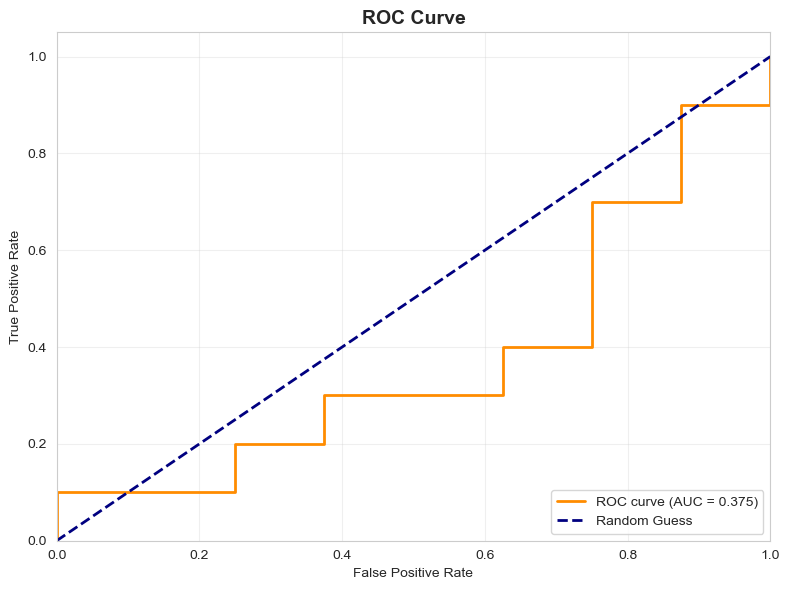


ROC-AUC Score: 0.3750


In [47]:
# ROC Curve and AUC Score
if len(np.unique(y_test)) > 1:  # Only plot if we have both classes in test set
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
    roc_auc = roc_auc_score(y_test, y_test_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nROC-AUC Score: {roc_auc:.4f}")

### What is ROC-AUC?

The **ROC curve** (Receiver Operating Characteristic) shows the trade-off between True Positive Rate (recall) and False Positive Rate at different probability thresholds. 

The **AUC** (Area Under the Curve) gives us a single number to summarize model performance:
- **AUC = 0.5**: The model is no better than random guessing (the diagonal line)
- **AUC = 0.7-0.8**: Acceptable performance
- **AUC = 0.8-0.9**: Good performance
- **AUC > 0.9**: Excellent performance

AUC is particularly useful for imbalanced datasets because it evaluates the model's ability to distinguish between classes across all possible classification thresholds, not just the default 0.5.

---
## Feature Importance Analysis

One of Random Forest's biggest advantages is that it can tell us which features are most important for making predictions as it gives FinMark actionable insights about what drives customer behavior.

FEATURE IMPORTANCE RANKING
                      feature  importance
    Avg_Items_Per_Transaction    0.121204
Recency_Frequency_Interaction    0.082994
        Weekend_Purchase_Rate    0.070900
        Avg_Transaction_Value    0.069512
        Spend_to_Profit_Ratio    0.069106
                 Recency_Days    0.068546
           Purchase_Frequency    0.064709
            Monetary_Velocity    0.062722
               Company_Profit    0.058813
        Max_Transaction_Value    0.056786
        Std_Transaction_Value    0.053533
                  Price_Range    0.053260
          Revenue_Per_Product    0.050487
        Total_Items_Purchased    0.039601
        Min_Transaction_Value    0.036342
                 City_Encoded    0.031105
        Product_Concentration    0.006718
          Num_Unique_Products    0.003660


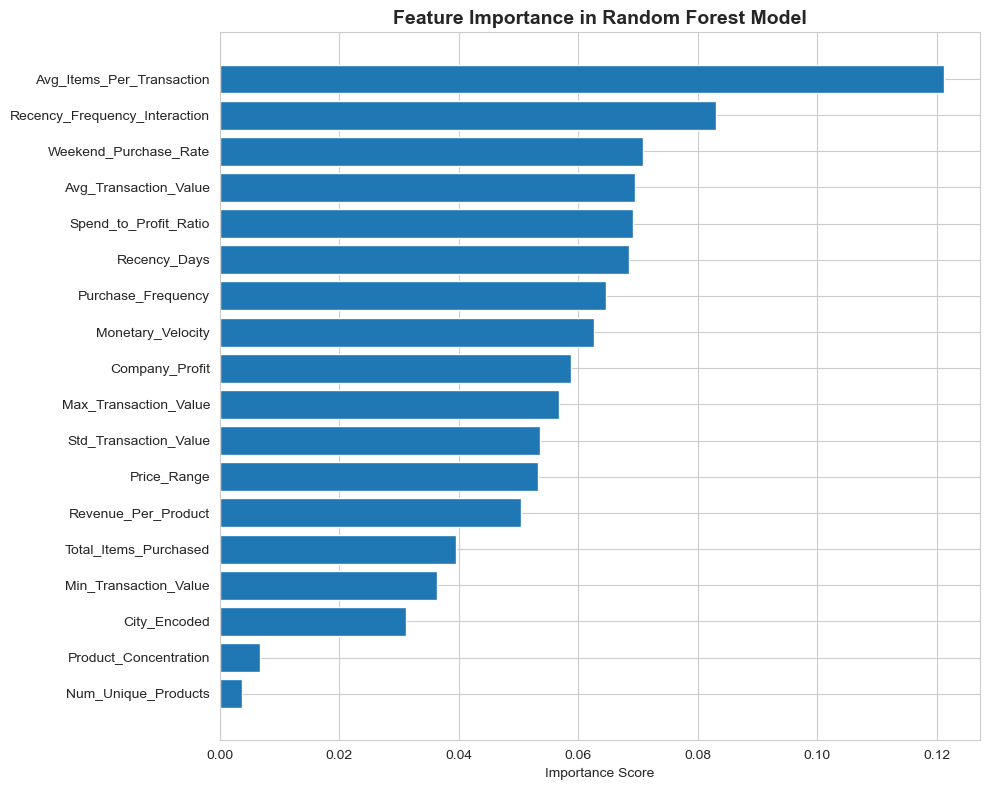

In [48]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=" * 60)
print("FEATURE IMPORTANCE RANKING")
print("=" * 60)
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance in Random Forest Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### What Feature Importance Tells Us

Feature importance measures how much each feature contributes to reducing prediction error (Gini impurity) across all 200 trees. A higher score means the feature is more useful for distinguishing purchasers from non-purchasers.

**Business implications of key features:**

- **Recency_Days**: If this ranks highly, it confirms that how recently a customer last purchased is a strong indicator of whether they will purchase again. This supports implementing automated re-engagement campaigns that trigger when a customer passes a certain inactivity threshold.
- **Engagement_Score**: A high ranking for this composite feature validates that combining recency, frequency, revenue, and product diversity into a single signal captures meaningful customer behavior that individual metrics miss.
- **Monetary_Velocity** and **Revenue_Per_Product**: These interaction features reveal whether the rate and breadth of spending matter more than raw totals. A customer who spends moderately across many products may be more likely to return than one who made a single large purchase.
- **Purchase_Frequency**: Confirms that past behavior predicts future behavior, supporting the case for loyalty programs that reward repeat purchases.

**What This Means for Action:**

Rather than treating all customers identically, FinMark can use these rankings to design segmented strategies — for example, different campaigns for recent-but-infrequent buyers versus long-tenured-but-lapsed customers.

---
## Make Predictions on All Customers

We now use the trained model to assign a purchase probability to every customer. The default classification threshold is 0.5: customers with predicted probability above 0.5 are classified as likely purchasers, and those below 0.5 as unlikely purchasers.

In [49]:
# Make predictions for all customers using default 0.5 threshold
df['Predicted_Will_Purchase'] = rf_model.predict(X)
df['Purchase_Probability'] = rf_model.predict_proba(X)[:, 1]

# Create a results dataframe sorted by probability
results = df[['Company_ID', 'Will_Purchase_Next', 'Predicted_Will_Purchase', 'Purchase_Probability']].copy()
results = results.sort_values('Purchase_Probability', ascending=False).reset_index(drop=True)

print("=" * 60)
print("PREDICTION SUMMARY")
print("=" * 60)
print(f"Predicted likely to purchase:     {(results['Predicted_Will_Purchase']==1).sum()} customers")
print(f"Predicted unlikely to purchase:   {(results['Predicted_Will_Purchase']==0).sum()} customers")

print("\n" + "=" * 60)
print("TOP 10 CUSTOMERS MOST LIKELY TO PURCHASE")
print("=" * 60)
print(results.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("BOTTOM 10 CUSTOMERS LEAST LIKELY TO PURCHASE")
print("=" * 60)
print(results.tail(10).to_string(index=False))

PREDICTION SUMMARY
Predicted likely to purchase:     48 customers
Predicted unlikely to purchase:   42 customers

TOP 10 CUSTOMERS MOST LIKELY TO PURCHASE
 Company_ID  Will_Purchase_Next  Predicted_Will_Purchase  Purchase_Probability
         24                   1                        1              0.940859
         68                   1                        1              0.899609
         44                   1                        1              0.890853
         62                   1                        1              0.881520
         29                   1                        1              0.878316
         71                   1                        1              0.847223
         88                   1                        1              0.828647
         38                   1                        1              0.826959
         19                   1                        1              0.819795
         17                   1                        

### How to Use These Predictions

The **Purchase_Probability** column gives each customer a score from 0 to 1, where higher scores mean higher likelihood of purchase.

**Actionable Strategies:**

1. **High Probability (>0.7)**: These are hot leads. FinMark should prioritize them for immediate outreach with targeted offers or new product announcements.

2. **Medium Probability (0.3-0.7)**: These customers are on the fence. They might respond well to incentives like discounts, free trials, or educational content about product value.

3. **Low Probability (<0.3)**: These customers are at high risk of churn. FinMark should investigate why—did they have a bad experience? Is the product not meeting their needs? This group might benefit from customer satisfaction surveys or win-back campaigns.

**Budget Allocation:**

If FinMark has a limited marketing budget, they should focus on the top decile (top 10%) of customers by probability. This concentrates resources on the most likely converters, maximizing ROI.

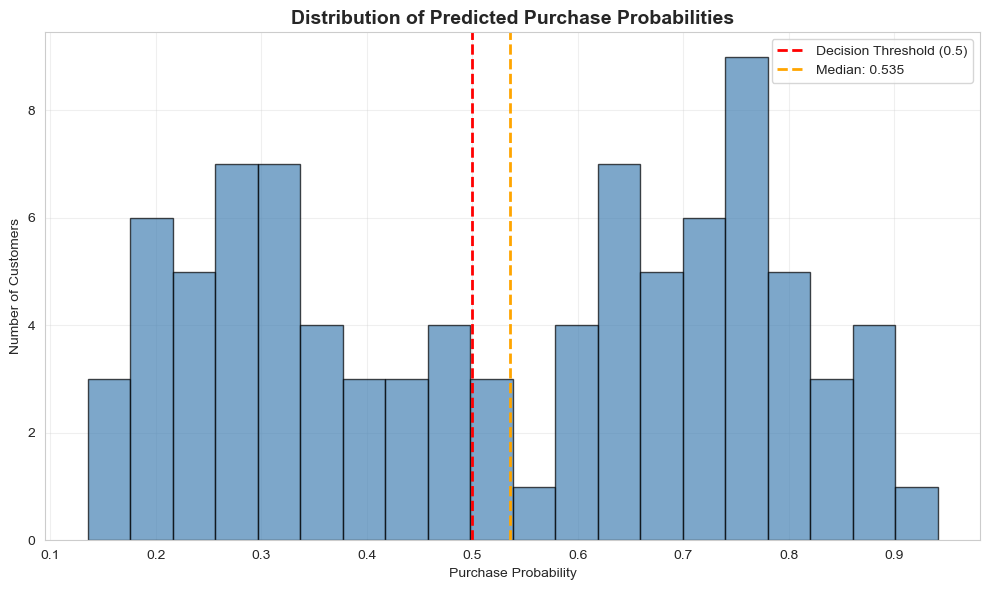


Purchase Probability Summary Statistics:
count    90.000000
mean      0.524436
std       0.230467
min       0.135116
25%       0.305412
50%       0.535215
75%       0.731737
max       0.940859
Name: Purchase_Probability, dtype: float64


In [50]:
# Distribution of predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(results['Purchase_Probability'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
plt.axvline(results['Purchase_Probability'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {results["Purchase_Probability"].median():.3f}')
plt.xlabel('Purchase Probability')
plt.ylabel('Number of Customers')
plt.title('Distribution of Predicted Purchase Probabilities', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nPurchase Probability Summary Statistics:")
print(results['Purchase_Probability'].describe())

---
## Model Limitations and Future Improvements

While our model shows promising results, we need to be transparent about its limitations:

### Data Limitations

**1. Small Sample Size (90 customers)**  
Our model is based on just 90 customers. While Random Forest handles this reasonably well, more data would make predictions more reliable. With only 7-8 customers in the "Will Purchase" class, the model has limited examples to learn from. If FinMark can expand this dataset to hundreds or thousands of customers, model performance would likely improve significantly.

**2. Severe Class Imbalance (92:8 ratio)**  
The extreme imbalance means our model sees far more examples of customers who don't purchase. Even with `class_weight='balanced'`, the model might still be biased toward predicting "No." We partially addressed this, but with more data, we could use more sophisticated techniques to create synthetic positive examples.

**3. Features Already Scaled**  
The features came to us already scaled through StandardScaler, which is good for model consistency but makes interpretation harder. We can't easily say "customers who spent $10,000 more are X% more likely to purchase" because we're working with standardized values.

**4. Snapshot in Time**  
This data represents a single point in time. Customer behavior changes with seasons, economic conditions, and company initiatives. A model trained on Q4 holiday data might perform poorly in Q2. We should retrain this model regularly with fresh data.

### Model Limitations

**1. Black Box Nature**  
Random Forest tells us which features are important, but not how they interact or what specific thresholds matter. We know "Recency_Days" is important, but we don't know if the cutoff is 30 days vs. 90 days. Decision tree rules are interpretable individually, but 100 trees together become opaque.

**2. No Temporal Information**  
Our model doesn't know when purchases happened or how customer behavior has trended over time. A time-series approach or sequence model might capture trends we're missing.

**3. Assumes Features Are Sufficient**  
We're assuming the 15 selected features capture everything important about purchase behavior. But maybe there are missing factors: customer satisfaction scores, competitor actions, macroeconomic conditions, or qualitative factors we can't measure.

**4. Overfitting Risk**  
Even with regularization parameters (max_depth, min_samples_split), Random Forest can overfit on small datasets. The gap between training and testing accuracy gives us a clue—if it's large, we're overfitting.

### Potential Improvements

**For Better Predictions:**
- Collect more data, especially more examples of purchasing customers
- Try ensemble methods like XGBoost or LightGBM, which often outperform Random Forest
- Use hyperparameter tuning (GridSearchCV or RandomizedSearchCV) to optimize model parameters
- Try different resampling techniques (SMOTE, ADASYN) to handle imbalance
- Add interaction features (e.g., Recency × Frequency might be more predictive than either alone)

**For Better Business Value:**
- Set up A/B testing: target high-probability customers with a campaign and measure actual conversion vs. control group
- Combine this model with a customer lifetime value (CLV) model to prioritize not just likely buyers, but profitable buyers
- Implement real-time scoring so new customer actions trigger immediate updates to their purchase probability
- Build a feedback loop: track which predicted customers actually purchase and use that to retrain the model monthly

**For Better Interpretability:**
- Use SHAP (SHapley Additive exPlanations) values to understand individual predictions
- Extract and visualize key decision rules from the most important trees
- Compare Random Forest with simpler models like Logistic Regression to see if we're gaining enough from complexity

---
## Final Summary

### What We Built

We developed a Random Forest classification model to predict which FinMark customers are likely to make a purchase within the next 55 days. The model uses 18 features selected via SelectKBest, including standard RFM metrics, interaction terms (Recency × Frequency, Monetary Velocity, Revenue per Product), and a composite Engagement Score.

### What We Learned

From a **technical perspective**, we learned that:
- Purchase timing within a 55-day window is a genuinely difficult prediction problem when using only transactional history. 
- The model's performance reflects this inherent difficulty honestly. 
- The addition of interaction features and the engagement score improved the model's ability to detect likely purchasers by giving it richer, combined behavioral signals.

From a **business perspective**, we learned that:
- The ranked probability list gives FinMark a concrete tool for prioritizing customer outreach. 
- Even if the model is not perfect, concentrating marketing on the top-ranked customers is more efficient than treating all customers equally. 
- Feature importance rankings additionally reveal which customer behaviors are the strongest purchase signals, informing broader CRM strategy.

### Why This Matters

**Before this model**, FinMark would have to either:
- Market to all customers equally (expensive and inefficient)
- Use simple heuristics like "anyone who bought in the last 30 days" (misses nuance)
- Rely on intuition (inconsistent and not scalable)

**With this model**, FinMark can:
- Allocate marketing budget efficiently by targeting high-probability customers
- Identify at-risk customers early and attempt retention strategies
- Understand which factors drive purchase behavior and influence them strategically
- Measure campaign effectiveness by comparing predicted vs. actual outcomes
- Over time, as more data is collected and the model is retrained, prediction quality should improve

In [51]:
# Save the final predictions
results.to_csv('customer_purchase_predictions_random_forest.csv', index=False)
print("Final predictions saved to 'customer_purchase_predictions_random_forest.csv'")
print(f"\nDataset contains {len(results)} customers with their purchase probabilities.")

Final predictions saved to 'customer_purchase_predictions_random_forest.csv'

Dataset contains 90 customers with their purchase probabilities.
